## Замечания:
Актуально:
* С дисбалансом из-за полупустых классов можно бороться либо удалением маленьких классов, либо **пересемплированием**. Пока выбираю второй вариант, но в любом случае чудес ждать от предсказания маленьких по объему классов не стоит - если в обучающей выборке есть 1 строка какого-то класса, значит он будет предсказывать этот класс исключительно при полном соответствии тестовых строк данной одной строке. 
*


Актуально для меня:
* Можно улучшить обработку текстовых данных (можно попробовать в сыром виде запихать в кэтбуст)
* Если лемматизация будет работать долго (есть такая вероятность) - можно поменять на стеммер

Старое:
* Время работы? - **нужно протестировать на больших датасетах**
* Полупустые классы из-за которых возникает дисбаланс - **бороться**

* Вариант с тем, что в одной колонке название характеристики, в другой значение будет работать плохо (вот пример), т.к. модели без разницы на порядок следования колонок
* Правильно ли я понимаю, что все колонки кроме ХК 1 и целевой имеют тип данных String?
* **Как предсказывать строки с пустыми значениями во всех колонках ХК? (может их сразу откидывать)?**
* Названия первой колонки должны быть всегда одинаковые
* !!!Важно!!! Будем заменять числовые факторы на категориальные, если в них маленькое количество уникальных значений или одно значение встречается очень часто
* Были ошибки в названиях колонок: 'ХК_ка т_01'

**Проблемы, решение которых нужно будет автоматизировать:**
* Несбалансированность классов
* Пропуски в данных
* Автоматическое кодирование текстовых столбцов

In [186]:
#!pip install loguru
#!pip install imblearn
#!pip install pymystem3
#!pip install catboost
#!pip install seaborn

In [15]:
import pandas as pd
import numpy as np
from loguru import logger
import re
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

#nltk.download('punkt')
#nltk.download('stopwords')

#### Глобальные переменные

In [3]:
# Максимальное количество уникальных значений для категориального фактора, при котором он может обрабатываться методом one-hot encoding (добавится максимум столько столбцов)
OneHotEncodingLimit = 30

### Работа с данными

In [4]:
df = pd.read_excel('data/tire_classificator_data.xlsx')
#df = pd.read_excel('data/paper_classificator_data.xlsx')

In [5]:
#df = df.drop('Историческое наименование', axis = 1)

In [6]:
df = df[df['ID класса (ТАРГЕТ)'].notna()]

In [7]:
df.head(1)

,ID класса (ТАРГЕТ),Наименование терминального класса,Код родительского класса,Наименование родительского класса,Историческое наименование,ХК_Кат_01,Значение ХК_Кат_01,ХК_Кат_02,Значение ХК_Кат_02,ХК_Кат_03,Значение ХК_Кат_03,ХК_Кат_04,Значение ХК_Кат_04,ХК_Кат_05,Значение ХК_Кат_05,ХК_Стр_01,Значение ХК_Стр_01,ХК_Булево_01,Значение ХК_Булево_01
0,12388594,Шины автомобильные зимние 215/75 R16,01.09.08.01,ШИНЫ АВТОМОБИЛЬНЫЕ,"Шины автомобильные зимние 215/75, R16, 116/114...",Производитель,GoodYear,Диаметр,R16,Размерность,215/75,Сезоность,зимние,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
target = df['ID класса (ТАРГЕТ)']

# Удалим все лишние текстовые столбцы кроме "Исторического наименования"
trainset_columns = []
for column in df.columns:
    if (column == 'Историческое наименование') or (re.fullmatch(r'ХК_.*', column)!=None) or (re.fullmatch(r'Значение.*', column)!=None):
        trainset_columns.append(column)

factors_df = df[trainset_columns]

#### Работаем с типами данных столбцов

In [9]:
def format_column_types(columns: list):
    '''
    Обрабатывает названия колонок из массива columns.
    Возвращает словарь с парами: название колонки - ее тип данных  
    '''
    feature_types_dict = {}
    for column in columns:
        type_pattern = r'ХК_([^_]+)_.*'
        if column[0:2] == 'ХК':
            feature_types_dict[column] = 'Кат'
        elif column[0:8]=='Значение':
            column_type = re.findall(type_pattern, column)[0]
            feature_types_dict[column] = column_type
        else:
            feature_types_dict[column] = 'Стр'
    return feature_types_dict

feature_types_dict = format_column_types(factors_df.columns)

In [10]:
def check_number_to_categorical(column: str, factor: pd.Series):
    logger.info(f'Начинаем проверку численного фактора {column}\n')
    logger.debug(f'Размер фактора:{factor.size}')
    logger.debug(f'Количество уникальных значений: {factor.drop_duplicates().size}')
    logger.debug(f'Процент заполненности фактора: {factor[factor.notnull()].size / factor.size * 100}%')
    popular_value = pd.DataFrame(factor.value_counts().sort_values(ascending=False).head(1)/factor[factor.notnull()].size*100)
    popular_value.columns = ['Частота']
    logger.debug(f'Cамое частое значение фактора: \n{popular_value}')
    
    if float(popular_value.iloc[0])>=50:
        logger.info(f'Переводим числовой фактор {column} в категориальный')
        return True
    
    
for feature in feature_types_dict.keys():
    if feature_types_dict.get(feature) == 'Стр':
        #logger.debug(f'Строковый фактор: {feature}')
        #todo ДОДЕЛАТЬ пока ничего не делаем, чтобы не потерять пропущенные значения при преобразовании в строковый формат
        factors_df_copy = factors_df.copy()
        factors_df[feature] = factors_df_copy[feature].astype(object)
    elif feature_types_dict.get(feature) == 'Булево':
        factors_df_copy = factors_df.copy()
        factors_df[feature] = factors_df_copy[feature].astype(bool)
    elif feature_types_dict.get(feature) == 'Числ':
        if check_number_to_categorical(feature, factors_df[feature]):
            feature_types_dict[feature] = 'Кат'
            factors_df_copy = factors_df.copy()
            factors_df[feature] = factors_df_copy[feature].astype(object)
        else:
            factors_df_copy = factors_df.copy()
            factors_df[feature] = factors_df_copy[feature].astype(float)
    elif feature_types_dict.get(feature) == 'Кат':
        logger.debug(f'Категориальный фактор: {feature}')
        #todo ДОДЕЛАТЬ преобразование категориальных колонок (пока не делаем, т.к. возможно будет catboost)


C:\Users\user\AppData\Local\Temp\ipykernel_16664\1022614043.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors_df[feature] = factors_df_copy[feature].astype(object)
2023-10-22 23:46:06.919 | DEBUG    | __main__:<module>:33 - Категориальный фактор: ХК_Кат_01
2023-10-22 23:46:06.921 | DEBUG    | __main__:<module>:33 - Категориальный фактор: Значение ХК_Кат_01
2023-10-22 23:46:06.924 | DEBUG    | __main__:<module>:33 - Категориальный фактор: ХК_Кат_02
2023-10-22 23:46:06.928 | DEBUG    | __main__:<module>:33 - Категориальный фактор: Значение ХК_Кат_02
2023-10-22 23:46:06.931 | DEBUG    | __main__:<module>:33 - Категориальный фактор: ХК_Кат_03
2023-10-22 23:46:06.932 | DEBUG    | __main__:<module>:33 - Категориальный фактор: Значение ХК_Кат

#### Заполняем пропуски в данных
В зависимости от типа данных колонки заполняем пропуски по-разному:
*   Стр -  т.к. переводим строки в числа, то пропущенные значение пусть будут = 0
*   Числ - #todo По умолчанию = 0. Если присутствует значение, количество которого в заполненных строках >=50% => то фактор станет категориальным, а не численным. 
*   Булево - #todo будем считать, что у нас всегда такие столбцы отвечают на вопрос: "Есть что-то? - Да/Нет". Если нет ответа => Нет
*   Кат - 'Emptyclass'

In [11]:
factors_df.isna().sum()

Историческое наименование     0
ХК_Кат_01                     0
Значение ХК_Кат_01            0
ХК_Кат_02                     0
Значение ХК_Кат_02            0
ХК_Кат_03                     0
Значение ХК_Кат_03            0
ХК_Кат_04                     0
Значение ХК_Кат_04            0
ХК_Кат_05                    40
Значение ХК_Кат_05           40
ХК_Стр_01                    49
Значение ХК_Стр_01           49
ХК_Булево_01                 40
Значение ХК_Булево_01         0
dtype: int64

In [12]:
not_empty_factors_df = factors_df.copy()
for column in not_empty_factors_df.columns:
    if feature_types_dict.get(column) == 'Кат':
        not_empty_factors_df.loc[not_empty_factors_df[column].isna(), column] = f'EmptyCat'
    elif feature_types_dict.get(column) == 'Числ':
        not_empty_factors_df.loc[not_empty_factors_df[column].isna(), column] = 0
    elif feature_types_dict.get(column) == 'Стр':
        not_empty_factors_df.loc[not_empty_factors_df[column].isna(), column] = ''
    elif feature_types_dict.get(column) == 'Булево':
        not_empty_factors_df.loc[not_empty_factors_df[column].isna(), column] = 0


In [13]:
not_empty_factors_df.count()

Историческое наименование    9151
ХК_Кат_01                    9151
Значение ХК_Кат_01           9151
ХК_Кат_02                    9151
Значение ХК_Кат_02           9151
ХК_Кат_03                    9151
Значение ХК_Кат_03           9151
ХК_Кат_04                    9151
Значение ХК_Кат_04           9151
ХК_Кат_05                    9151
Значение ХК_Кат_05           9151
ХК_Стр_01                    9151
Значение ХК_Стр_01           9151
ХК_Булево_01                 9151
Значение ХК_Булево_01        9151
dtype: int64

#### Кодируем переменные
* bag_of_words - пока остановимся на нем

In [62]:
russian_stopwords = stopwords.words("russian")
mystem = Mystem()
stemmer = SnowballStemmer("russian")

def text_preprocessing(text):
    #tokens = mystem.lemmatize(text)
    tokens = [stemmer.stem(token) for token in text.split() if token not in russian_stopwords and token != " "  and token.strip() not in punctuation]
    tokens = ' '.join(tokens)
    return tokens

def text_feature_preprocessing(text_feature):
    '''
    Функция преобразования текстовых факторов
    - Переводим в нижний регистр
    - Удаляем знаки препинания
    - Удаляем стоп слова
    - Проводим лемматизацию
    '''
    processed_feature = []
    text_feature = text_feature.replace(r'[^\w\s]',' ', regex=True).replace(r'\s+',' ', regex=True).str.lower()
    processed_text_feature = text_feature.apply(text_preprocessing)
    return processed_text_feature
    #return text_feature

vectorizer = TfidfVectorizer(
        min_df = 20,
        analyzer='word',
        stop_words = russian_stopwords
    )

def handle_text_feature(text_feature: pd.Series):
    '''
    Функция обработки строкового фактора:
    - Проводим препроцессинг
    - Формируем "Мешок строк" (bag of words)
    '''
    #text_feature = text_feature.drop_duplicates()
    processed_text_feature = text_feature_preprocessing(text_feature)
    
    vectorizer.fit(processed_text_feature)
    vectorized_text_feature = pd.DataFrame(vectorizer.transform(processed_text_feature).toarray())

    # Удалим неинформативные столбцы
    informative_word_columns = vectorized_text_feature.sum()[
            (vectorized_text_feature.sum()>=vectorized_text_feature.shape[1]*0.01) &
            (vectorized_text_feature.sum()!=vectorized_text_feature.shape[1])
        ].index 
    handled_text_feature = vectorized_text_feature[informative_word_columns]
    handled_text_feature = handled_text_feature.fillna('EmptyStr')
    handled_text_feature.columns = pd.Series(vectorizer.get_feature_names_out())[informative_word_columns]
    return handled_text_feature

In [63]:
from sklearn.preprocessing import LabelEncoder

def handle_cat_feature(cat_feature: pd.Series):
    cat_feature = cat_feature.astype(str)
    unique_values_count = cat_feature.drop_duplicates().size
    if unique_values_count <= OneHotEncodingLimit:
        #OneHotEncoding
        cat_feature_encoded = pd.get_dummies(cat_feature)
    else:
        #LabelEncoding - чтобы сильно не увеличивать количество факторов
        le = LabelEncoder()
        cat_feature_encoded = pd.DataFrame(le.fit_transform(cat_feature))
    return cat_feature_encoded

In [64]:
trainset = pd.DataFrame()
copy_df = not_empty_factors_df.copy()

for feature in feature_types_dict:
    if feature_types_dict.get(feature) == 'Стр':
        handled_feature = handle_text_feature(not_empty_factors_df[feature])
        handled_feature = handled_feature.fillna('')
        #handled_feature = handle_text_feature(copy_df[feature])
    elif feature_types_dict.get(feature) == 'Кат':
        handled_feature = handle_cat_feature(not_empty_factors_df[feature])
        #handled_feature = handle_cat_feature(copy_df[feature])
    else:
        handled_feature = pd.DataFrame(not_empty_factors_df[feature])
        #handled_feature = pd.DataFrame(copy_df[feature])
    handled_feature.columns = [str(col)+'_'+str(feature) for col in handled_feature.columns]  
    trainset = pd.concat([trainset,handled_feature],axis=1)

In [28]:
from sklearn.feature_selection import chi2

features_chi2 = chi2(vectorizer.get_feature_names_out())
indices = np.argsort(features_chi2[0])
feature_names = np.array(vectorizer.get_feature_names_out())[indices]

TypeError: chi2() missing 1 required positional argument: 'y'

#### Сэмплируем классы, в которых всего 1 экземпляр и делим на обучающую и тестовую выборки

In [65]:
target.value_counts()

ID класса (ТАРГЕТ)
20000075    97
20000109    91
3584225     87
20000112    85
20000343    80
            ..
20000203     1
20000280     1
20000249     1
20000582     1
20000561     1
Name: count, Length: 645, dtype: int64

In [66]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
trainset_res, target_res = ros.fit_resample(trainset, target)
target_res.value_counts()

ID класса (ТАРГЕТ)
12388594    97
20000029    97
20000234    97
20000214    97
20000069    97
            ..
20000479    97
20000511    97
20000542    97
20000587    97
20000561    97
Name: count, Length: 645, dtype: int64

#### Уменьшаем размерность

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 15)
reproduced_trainset = pca.fit_transform(trainset_res)

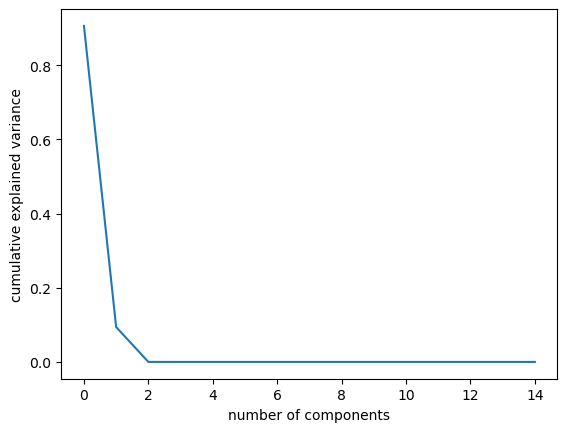

In [75]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [76]:
reproduced_trainset.shape

(62565, 15)

In [270]:
trainset_res.shape

(62565, 995)

In [271]:
target_res.shape

(62565,)

In [85]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(
    #trainset_res,
    reproduced_trainset, 
    target_res, 
    test_size=0.9, 
    random_state=42,
    #stratify=target    
) 

In [86]:
train_data.shape

(6256, 15)

#### RandomForestClassifier

In [87]:
from sklearn.ensemble import RandomForestClassifier

In [88]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(train_data, train_labels)

RandomForestClassifier(random_state=0)

In [89]:
predicted_labels = rfc.predict(test_data)

In [90]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(test_labels, predicted_labels)
report = classification_report(test_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.8406293842902556
Classification Report:
               precision    recall  f1-score   support

     3284155       0.58      0.70      0.63        87
     3284156       0.91      0.34      0.49        92
     3584204       0.78      0.80      0.79        81
     3584210       0.82      0.55      0.66        89
     3584225       0.38      0.48      0.42        86
     3856283       0.47      0.64      0.55        89
     3856634       0.70      0.54      0.61        90
     3856718       1.00      0.70      0.82        92
     4420908       0.60      0.39      0.47        90
     4444696       0.71      0.70      0.71        88
     4444725       0.90      0.93      0.92        87
     7816483       0.93      0.76      0.84        87
     7816502       0.54      0.50      0.52        90
     7816558       0.79      0.16      0.27        92
     7820678       0.79      0.67      0.72        87
     7820846       0.60      0.68      0.64        85
     7820887       1.00     

#### Обучим модель CatBoostClassifier на подготовленных данных

In [113]:
from catboost import CatBoostClassifier

In [145]:
model = CatBoostClassifier(loss_function='MultiClass', logging_level='Verbose')

#Нужно контролить переобоучение, правильно выставить learning_rate

grid_small = {'learning_rate': [0.01],# 0.03, 0.09],
        'depth': [ 3]
        #'l2_leaf_reg': [1, 3, 5, 7, 9]
        }


grid_full = {'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09],
        'depth': [3, 4, 6, 7, 8, 9, 10],
        #'early_stopping_rounds': True,
        'l2_leaf_reg': [1, 3, 5, 7, 9]
        }

grid_search_result = model.grid_search(
        grid_small,
        X=train_data,
        y=train_labels,
)

0:	learn: 5.8021328	test: 5.8028781	best: 5.8028781 (0)	total: 4.36s	remaining: 1h 12m 36s
1:	learn: 5.7600391	test: 5.7615252	best: 5.7615252 (1)	total: 8.73s	remaining: 1h 12m 36s
2:	learn: 5.7070225	test: 5.7088004	best: 5.7088004 (2)	total: 13.3s	remaining: 1h 13m 40s
3:	learn: 5.6601069	test: 5.6619228	best: 5.6619228 (3)	total: 17.8s	remaining: 1h 13m 55s
4:	learn: 5.6294886	test: 5.6320792	best: 5.6320792 (4)	total: 22.2s	remaining: 1h 13m 40s
5:	learn: 5.5898019	test: 5.5922128	best: 5.5922128 (5)	total: 26.7s	remaining: 1h 13m 44s
6:	learn: 5.5461853	test: 5.5487469	best: 5.5487469 (6)	total: 31.3s	remaining: 1h 13m 58s
7:	learn: 5.5087435	test: 5.5118871	best: 5.5118871 (7)	total: 35.8s	remaining: 1h 14m 4s
8:	learn: 5.4728678	test: 5.4764603	best: 5.4764603 (8)	total: 40.5s	remaining: 1h 14m 24s
9:	learn: 5.4400767	test: 5.4432583	best: 5.4432583 (9)	total: 45.3s	remaining: 1h 14m 42s
10:	learn: 5.3952072	test: 5.3984957	best: 5.3984957 (10)	total: 50s	remaining: 1h 14m 52s


KeyboardInterrupt: 

In [ ]:
model.fit(train_data, train_labels)
preds_labels = model.predict(test_data)

In [73]:
model_2 = CatBoostClassifier(loss_function='MultiClass', logging_level='Verbose', learning_rate = 0.3, depth = 4)

#Нужно контролить переобоучение, правильно выставить learning_rate, метрика и функция потерь
model_2.fit(train_data, train_labels)
preds_labels = model_2.predict(test_data)

0:	learn: 4.4773927	total: 27.6s	remaining: 7h 40m 22s
1:	learn: 4.1295189	total: 54.8s	remaining: 7h 35m 20s
2:	learn: 3.5977834	total: 1m 21s	remaining: 7h 33m 10s


KeyboardInterrupt: 

In [71]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(test_labels, preds_labels)
report = classification_report(test_labels, preds_labels)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

ValueError: Found input variables with inconsistent numbers of samples: [18770, 437]

#### Удалим бесполезные факторы которые состоят из 1 уникального значения

In [ ]:
#Делаем это после кодирования категориалььных переменных
#for column in factors_df.columns:
#    unique_values_count = factors_df[column].drop_duplicates().size
#    if unique_values_count == 1:
#        new_factors_df = factors_df.drop(column, axis = 1)

In [ ]:
#new_factors_df.info()

In [ ]:
#new_factors_df['Наименование терминального класса'].value_counts()

* Удалить колонки для неполного соответствия: если есть [1,2,3,4] - удалить одну, чтобы не было зависимости
* Удалить строки без характеристик
* Отбор на основе важности признаков